In [19]:
"""
Laboratorio: Técnicas de Bandits en Ms. Pac-Man
Implementación de 4 técnicas de exploración vs explotación:
1. ε-greedy
2. Valores iniciales optimistas
3. UCB (Upper Confidence Bound)
4. Algoritmos de Gradiente

Basado en el cuadernillo 02_bandits.ipynb
"""

# Instalar dependencias necesarias
!pip install gymnasium[atari]
!pip install ale-py
!pip install autorom
!autorom --accept-license

/bin/bash: line 1: autorom: command not found


In [20]:
import ale_py
print(ale_py.__version__)

0.11.0


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
from collections import defaultdict

# Configuración inicial
np.random.seed(42)

In [22]:
class MsPacManBandits:
    def __init__(self):
        """
        Inicializa el entorno de Ms. Pac-Man para bandits.
        Simplificamos las acciones a las 4 direcciones principales.
        """
        self.env = gym.make('ALE/MsPacman-v5', render_mode=None)

        # Simplificamos a 4 acciones principales (como en el Whac-A-Mole original)
        # 0: No-op, 1: Up, 2: Right, 3: Down, 4: Left
        self.actions = [0, 1, 2, 3, 4]  # 5 acciones como en el ejemplo original
        self.n_actions = len(self.actions)

        print(f"Entorno Ms. Pac-Man inicializado con {self.n_actions} acciones")
        print(f"Acciones disponibles: {self.actions}")

    def get_reward(self, action):
        """
        Ejecuta una acción y devuelve la recompensa.
        Normaliza la recompensa para que sea comparable con el ejemplo original.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Normalizar recompensa (Ms. Pac-Man da recompensas grandes)
        # La dividimos por 10 para tener valores más manejables como en el ejemplo
        normalized_reward = reward / 10.0

        # Si el juego termina, reiniciamos
        if terminated or truncated:
            self.env.reset()

        return normalized_reward

    def reset(self):
        """Reinicia el entorno"""
        return self.env.reset()

    def close(self):
        """Cierra el entorno"""
        self.env.close()

In [23]:
def softmax(x):
    """Función softmax para algoritmos de gradiente"""
    exp_x = np.exp(x - np.max(x))  # Estabilidad numérica
    return exp_x / np.sum(exp_x)

In [24]:
def run_epsilon_greedy_experiment(env, partidas=500, turnos=200, epsilons=[0, 0.01, 0.1]):
    """
    Técnica 1: ε-greedy
    Implementación exacta del cuadernillo adaptada a Ms. Pac-Man
    """
    print("=== Ejecutando experimento ε-greedy ===")

    recompensas_medias = np.zeros((len(epsilons), turnos))
    acciones_optimas = np.zeros((len(epsilons), turnos))

    # Estimamos la mejor acción empíricamente
    print("Estimando mejor acción...")
    mejor_accion_rewards = []
    for action in env.actions:
        env.reset()
        total_reward = 0
        for _ in range(50):  # Muestreo para estimar
            reward = env.get_reward(action)
            total_reward += reward
        mejor_accion_rewards.append(total_reward / 50)

    mejor_accion = env.actions[np.argmax(mejor_accion_rewards)]
    print(f"Mejor acción estimada: {mejor_accion}")

    for ej in range(partidas):
        if (ej + 1) % 100 == 0:
            print(f"Partida {ej + 1}/{partidas}")

        for i, e in enumerate(epsilons):
            env.reset()
            Q = {k: 0 for k in env.actions}
            acciones_count = {k: 0 for k in env.actions}
            recompensas_sum = {k: 0 for k in env.actions}

            for exp in range(turnos):
                # Elegir acción según ε-greedy
                if np.random.uniform(0, 1) < e:
                    # Acción aleatoria (exploración)
                    a = np.random.choice(env.actions)
                else:
                    # Acción con mayor valor (explotación)
                    maxQ = -1000
                    a = env.actions[0]
                    for action in env.actions:
                        if Q[action] > maxQ:
                            maxQ = Q[action]
                            a = action

                # Ejecutar acción y obtener recompensa
                recompensa = env.get_reward(a)

                # Actualizar estadísticas
                acciones_count[a] += 1
                recompensas_sum[a] += recompensa
                Q[a] = recompensas_sum[a] / acciones_count[a]

                # Guardar métricas
                recompensas_medias[i][exp] += recompensa
                acciones_optimas[i][exp] += (a == mejor_accion)

    recompensas_medias /= partidas
    acciones_optimas /= partidas

    return recompensas_medias, acciones_optimas, epsilons

In [25]:
def run_optimistic_initialization_experiment(env, partidas=500, turnos=200):
    """
    Técnica 2: Valores iniciales optimistas
    Implementación del cuadernillo adaptada a Ms. Pac-Man
    """
    print("=== Ejecutando experimento Valores Optimistas ===")

    epsilons = [0, 0.1]  # Greedy optimista vs ε-greedy normal
    alpha = 0.5
    recompensas_medias = np.zeros((len(epsilons), turnos))
    acciones_optimas = np.zeros((len(epsilons), turnos))

    # Mejor acción estimada
    mejor_accion_rewards = []
    for action in env.actions:
        env.reset()
        total_reward = 0
        for _ in range(50):
            reward = env.get_reward(action)
            total_reward += reward
        mejor_accion_rewards.append(total_reward / 50)

    mejor_accion = env.actions[np.argmax(mejor_accion_rewards)]

    for ej in range(partidas):
        if (ej + 1) % 100 == 0:
            print(f"Partida {ej + 1}/{partidas}")

        for i, e in enumerate(epsilons):
            env.reset()
            Q = {k: 0 for k in env.actions}

            # Inicialización optimista para agente greedy
            if e == 0:
                Q = {k: 10 for k in env.actions}  # Valores altos optimistas

            for exp in range(turnos):
                # Elegir acción
                if np.random.uniform(0, 1) < e:
                    a = np.random.choice(env.actions)
                else:
                    maxQ = -1000
                    a = env.actions[0]
                    for action in env.actions:
                        if Q[action] > maxQ:
                            maxQ = Q[action]
                            a = action

                # Ejecutar y actualizar (implementación incremental)
                recompensa = env.get_reward(a)
                Q[a] += alpha * (recompensa - Q[a])

                recompensas_medias[i][exp] += recompensa
                acciones_optimas[i][exp] += (a == mejor_accion)

    recompensas_medias /= partidas
    acciones_optimas /= partidas

    return recompensas_medias, acciones_optimas, epsilons

In [26]:
def run_ucb_experiment(env, partidas=500, turnos=200, c=1):
    """
    Técnica 3: UCB (Upper Confidence Bound)
    Implementación del cuadernillo adaptada a Ms. Pac-Man
    """
    print("=== Ejecutando experimento UCB ===")

    alpha = 0.5
    methods = ['UCB', 'ε-greedy']
    epsilon = 0.1
    recompensas_medias = np.zeros((len(methods), turnos))
    acciones_optimas = np.zeros((len(methods), turnos))

    # Mejor acción estimada
    mejor_accion_rewards = []
    for action in env.actions:
        env.reset()
        total_reward = 0
        for _ in range(50):
            reward = env.get_reward(action)
            total_reward += reward
        mejor_accion_rewards.append(total_reward / 50)

    mejor_accion = env.actions[np.argmax(mejor_accion_rewards)]

    for ej in range(partidas):
        if (ej + 1) % 100 == 0:
            print(f"Partida {ej + 1}/{partidas}")

        for i, method in enumerate(methods):
            env.reset()
            Q = {k: 0 for k in env.actions}
            acciones_count = {k: 1 for k in env.actions}  # Inicializar en 1 para UCB

            for exp in range(turnos):
                if method == 'UCB':
                    # Selección UCB
                    maxA = -1000
                    a = env.actions[0]
                    for action in env.actions:
                        ucb_value = Q[action] + c * math.sqrt(math.log(exp + 1) / acciones_count[action])
                        if ucb_value > maxA:
                            maxA = ucb_value
                            a = action
                else:
                    # ε-greedy para comparación
                    if np.random.uniform(0, 1) < epsilon:
                        a = np.random.choice(env.actions)
                    else:
                        maxQ = -1000
                        a = env.actions[0]
                        for action in env.actions:
                            if Q[action] > maxQ:
                                maxQ = Q[action]
                                a = action

                # Ejecutar y actualizar
                acciones_count[a] += 1
                recompensa = env.get_reward(a)
                Q[a] += alpha * (recompensa - Q[a])

                recompensas_medias[i][exp] += recompensa
                acciones_optimas[i][exp] += (a == mejor_accion)

    recompensas_medias /= partidas
    acciones_optimas /= partidas

    return recompensas_medias, acciones_optimas, methods

In [27]:
def run_gradient_bandit_experiment(env, partidas=500, turnos=200, alphas=[0.1, 0.4]):
    """
    Técnica 4: Algoritmos de Gradiente
    Implementación del cuadernillo adaptada a Ms. Pac-Man
    """
    print("=== Ejecutando experimento Algoritmos de Gradiente ===")

    recompensas_medias = np.zeros((len(alphas), turnos))
    acciones_optimas = np.zeros((len(alphas), turnos))

    # Mejor acción estimada
    mejor_accion_rewards = []
    for action in env.actions:
        env.reset()
        total_reward = 0
        for _ in range(50):
            reward = env.get_reward(action)
            total_reward += reward
        mejor_accion_rewards.append(total_reward / 50)

    mejor_accion = env.actions[np.argmax(mejor_accion_rewards)]

    for ej in range(partidas):
        if (ej + 1) % 100 == 0:
            print(f"Partida {ej + 1}/{partidas}")

        for i, alpha in enumerate(alphas):
            env.reset()
            H = np.zeros(env.n_actions)  # Preferencias iniciales
            pi = softmax(H)  # Probabilidades iniciales
            recompensas = []

            for exp in range(turnos):
                # Elegir acción según probabilidades
                action_idx = np.random.choice(env.n_actions, p=pi)
                a = env.actions[action_idx]

                # Ejecutar acción
                recompensa = env.get_reward(a)
                recompensas.append(recompensa)
                recompensa_media = np.mean(recompensas)

                # Actualizar preferencias (algoritmo de gradiente)
                for j in range(env.n_actions):
                    if j == action_idx:
                        H[j] += alpha * (recompensa - recompensa_media) * (1 - pi[j])
                    else:
                        H[j] -= alpha * (recompensa - recompensa_media) * pi[j]

                # Actualizar probabilidades
                pi = softmax(H)

                recompensas_medias[i][exp] += recompensa
                acciones_optimas[i][exp] += (a == mejor_accion)

    recompensas_medias /= partidas
    acciones_optimas /= partidas

    return recompensas_medias, acciones_optimas, alphas

In [28]:
# Inicializar entorno
print("Iniciando laboratorio de Bandits en Ms. Pac-Man")
print("=" * 50)

env = MsPacManBandits()

Iniciando laboratorio de Bandits en Ms. Pac-Man
Entorno Ms. Pac-Man inicializado con 5 acciones
Acciones disponibles: [0, 1, 2, 3, 4]


In [29]:
# Experimento 1: ε-greedy
print("\n1. TÉCNICA ε-GREEDY")
rewards_eps, optimal_eps, epsilons = run_epsilon_greedy_experiment(env)


1. TÉCNICA ε-GREEDY
=== Ejecutando experimento ε-greedy ===
Estimando mejor acción...
Mejor acción estimada: 0
Partida 100/500
Partida 200/500
Partida 300/500
Partida 400/500
Partida 500/500


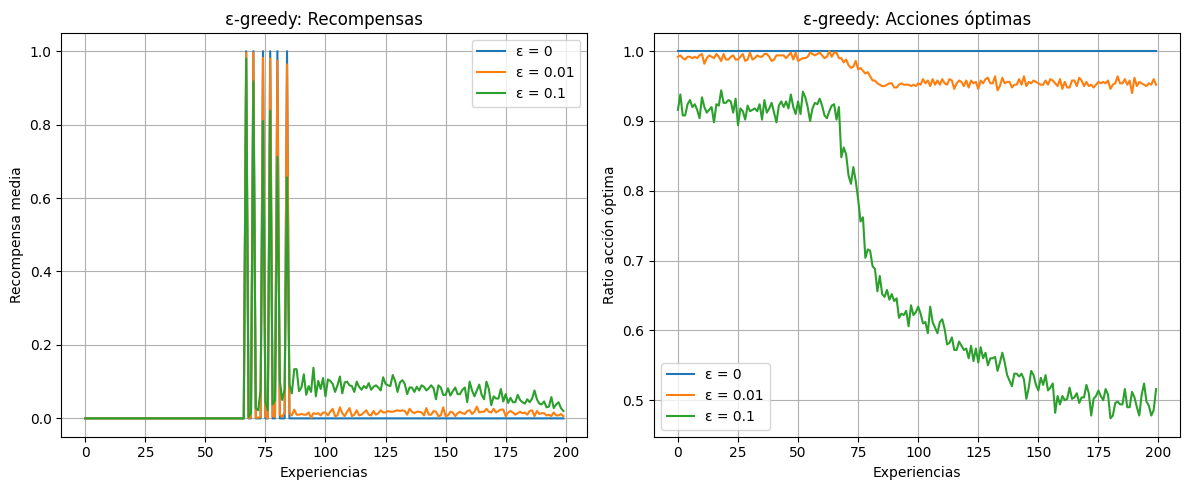

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, e in enumerate(epsilons):
    plt.plot(rewards_eps[i], label=f'ε = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.title('ε-greedy: Recompensas')

plt.subplot(1, 2, 2)
for i, e in enumerate(epsilons):
    plt.plot(optimal_eps[i], label=f'ε = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.title('ε-greedy: Acciones óptimas')

plt.tight_layout()
plt.show()

In [31]:
print("\n2. TÉCNICA VALORES INICIALES OPTIMISTAS")
rewards_opt, optimal_opt, eps_opt = run_optimistic_initialization_experiment(env)


2. TÉCNICA VALORES INICIALES OPTIMISTAS
=== Ejecutando experimento Valores Optimistas ===
Partida 100/500
Partida 200/500
Partida 300/500
Partida 400/500
Partida 500/500


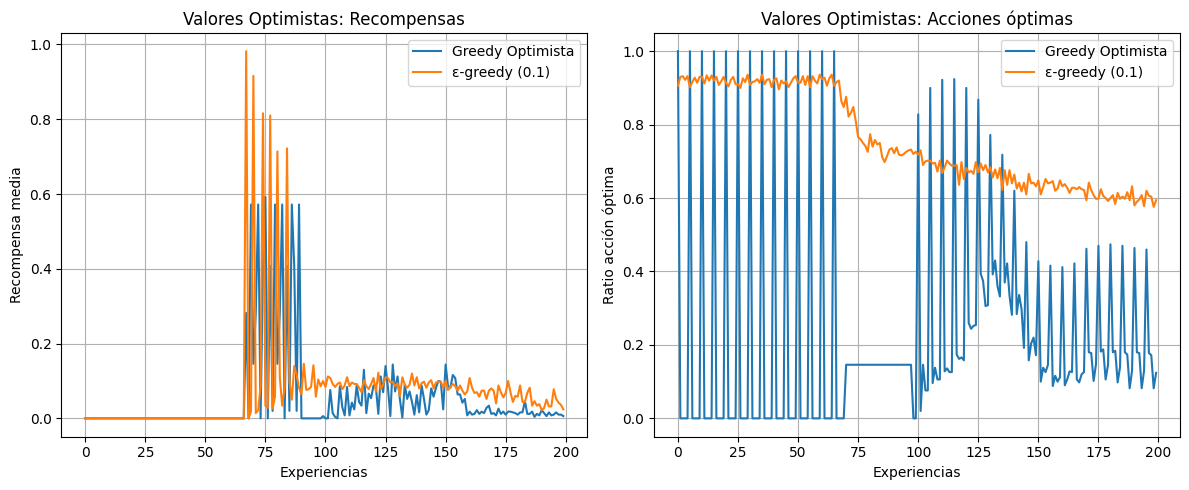

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
labels = ['Greedy Optimista', 'ε-greedy (0.1)']
for i, label in enumerate(labels):
    plt.plot(rewards_opt[i], label=label)
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.title('Valores Optimistas: Recompensas')

plt.subplot(1, 2, 2)
for i, label in enumerate(labels):
    plt.plot(optimal_opt[i], label=label)
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.title('Valores Optimistas: Acciones óptimas')

plt.tight_layout()
plt.show()

In [33]:
print("\n3. TÉCNICA UCB (UPPER CONFIDENCE BOUND)")
rewards_ucb, optimal_ucb, methods_ucb = run_ucb_experiment(env)


3. TÉCNICA UCB (UPPER CONFIDENCE BOUND)
=== Ejecutando experimento UCB ===
Partida 100/500
Partida 200/500
Partida 300/500
Partida 400/500
Partida 500/500


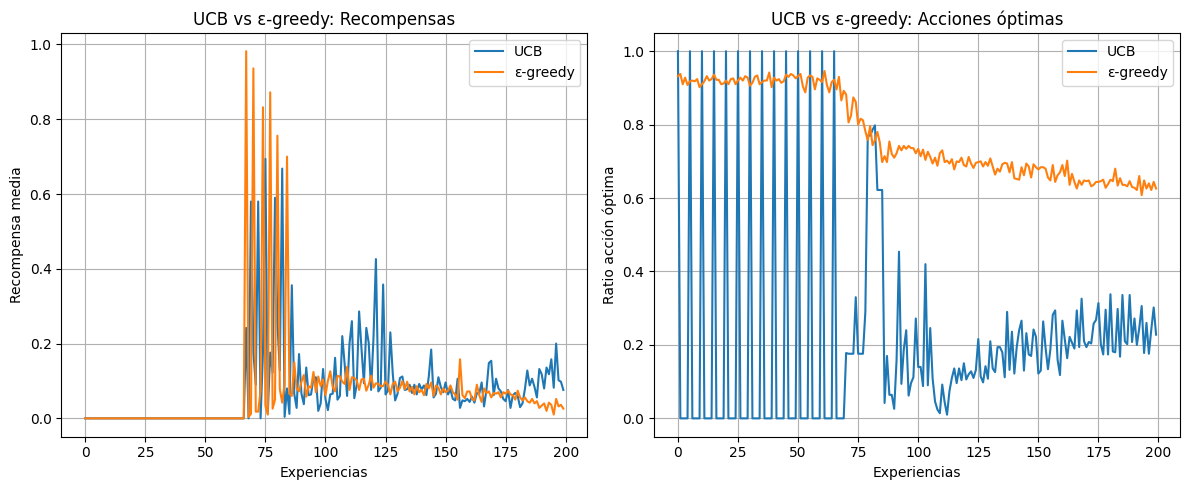

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, method in enumerate(methods_ucb):
    plt.plot(rewards_ucb[i], label=method)
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.title('UCB vs ε-greedy: Recompensas')

plt.subplot(1, 2, 2)
for i, method in enumerate(methods_ucb):
    plt.plot(optimal_ucb[i], label=method)
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.title('UCB vs ε-greedy: Acciones óptimas')

plt.tight_layout()
plt.show()

In [35]:
# Experimento 4: Algoritmos de Gradiente
print("\n4. TÉCNICA ALGORITMOS DE GRADIENTE")
rewards_grad, optimal_grad, alphas_grad = run_gradient_bandit_experiment(env)


4. TÉCNICA ALGORITMOS DE GRADIENTE
=== Ejecutando experimento Algoritmos de Gradiente ===
Partida 100/500
Partida 200/500
Partida 300/500
Partida 400/500
Partida 500/500


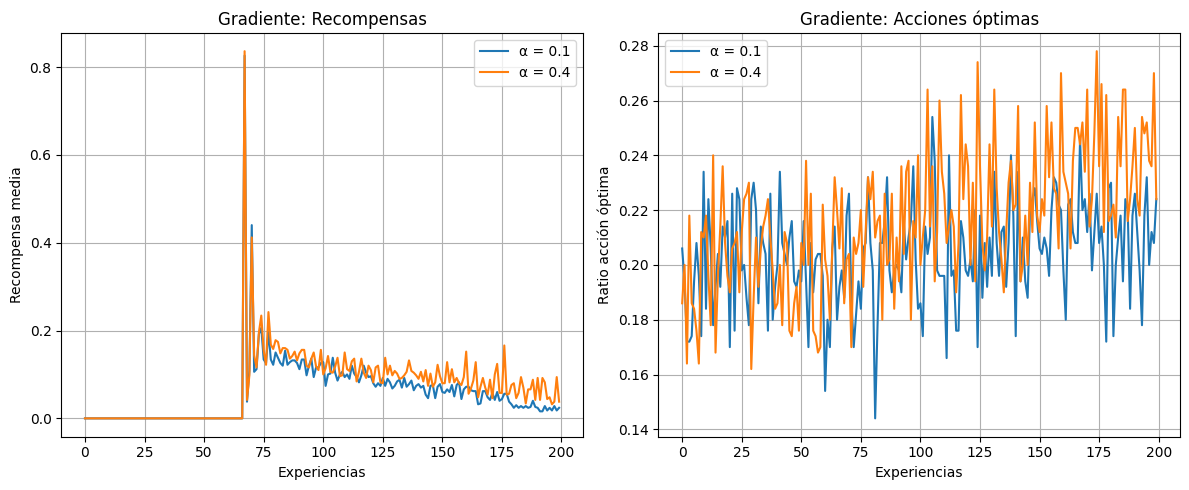

In [36]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, alpha in enumerate(alphas_grad):
    plt.plot(rewards_grad[i], label=f'α = {alpha}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.title('Gradiente: Recompensas')

plt.subplot(1, 2, 2)
for i, alpha in enumerate(alphas_grad):
    plt.plot(optimal_grad[i], label=f'α = {alpha}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.title('Gradiente: Acciones óptimas')

plt.tight_layout()
plt.show()

In [37]:
env.close()

print("\n" + "=" * 50)
print("LABORATORIO COMPLETADO EXITOSAMENTE")
print("Se han ejecutado las 4 técnicas de bandits:")
print("- ε-greedy")
print("- Valores iniciales optimistas")
print("- UCB (Upper Confidence Bound)")
print("- Algoritmos de Gradiente")
print("=" * 50)


LABORATORIO COMPLETADO EXITOSAMENTE
Se han ejecutado las 4 técnicas de bandits:
- ε-greedy
- Valores iniciales optimistas
- UCB (Upper Confidence Bound)
- Algoritmos de Gradiente
